![title](https://cdn.igromania.ru/mnt/magazines/b/e/8/3/a/232/imp/1/fe51ec9177e4f18d_631xH.jpg)

# **СВОДНЫЙ ПРОЕКТ 1 : ИССЛЕДОВАНИЕ РЫНКА КОМПЬЮТЕРНЫХ ИГР**

# Импорт и предобработка данных

**Импорт библиотек и настройки**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
# import missingno # библиотека для визуализации пропусков # не работает в сетевой версии
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats as st

warnings.filterwarnings('ignore')
#sns.set_palette('Set2')
pd.set_option('display.max_rows', 500) # показывает все строки, если количество строк в выводе не больше 500.
pd.set_option('display.max_columns', 100) # показывает все строки, если количество строк в выводе не больше 500.
pd.set_option('display.float_format', '{:.2f}'.format)

---
**Импорт данных**

In [2]:
# импортируем данные из csv файла
#raw_data = pd.read_csv('games.csv')
try:
    raw_data = pd.read_csv('/datasets/games.csv') # путь к данным для сетевой версии
except: 
    raw_data = pd.read_csv('games.csv')  # путь к данным для локальной версии

In [3]:
# отобразим информацию по импортированному dataframe
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


---
**Переименование столбцов**


In [4]:
# приведем названия всех столбцов к нижнему регистру
raw_data = raw_data.rename(columns={
    "Name": "name", 
    "Platform": "platform", 
    "Year_of_Release": "year_of_release", 
    "Genre": "genre", 
    "NA_sales": "na_sales", 
    "EU_sales": "eu_sales", 
    "JP_sales": "jp_sales",
    "Other_sales": "other_sales",
    "Critic_Score": "critic_score",
    "User_Score": "user_score",
    "Rating": "rating"})

raw_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


---
**Заполнение пропусков**

In [5]:
# создадим копию данных good_data для последующей обработки
good_data = raw_data.copy()

In [6]:
# отобразим данные по пропускам

# закомментировал

# missingno.matrix(good_data,figsize=(10,5), fontsize=12, label_rotation=90);

# посчитаем количество, процент пропусков и медианные значения по каждому столбцу
print('Количество строк в выборке:', len(good_data))
display(
 pd.concat([
     good_data.isna().sum(), 
     good_data.isna().mean()*100
 ],axis=1).rename(columns=({0:'empties', 1:'empties%' }))
)

Количество строк в выборке: 16715


,empties,empties%
name,2,0.01
platform,0,0.00
year_of_release,269,1.61
genre,2,0.01
na_sales,0,0.00
eu_sales,0,0.00
jp_sales,0,0.00
other_sales,0,0.00
critic_score,8578,51.32
user_score,6701,40.09


In [7]:
print('Объемы продаж по играм с пропусками в "name", "year_of_release", "genre"')
(
    display(good_data
    .query('name.isna() or genre.isna() or year_of_release.isna()')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum())
)

print('\nСуммарные объемы продаж в выборке')
(
    display(good_data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum())
)


Объемы продаж по играм с пропусками в "name", "year_of_release", "genre"


na_sales      60.93
eu_sales      24.99
jp_sales       6.73
other_sales    8.69
dtype: float64


Суммарные объемы продаж в выборке


na_sales      4402.35
eu_sales      2424.67
jp_sales      1297.37
other_sales    791.32
dtype: float64

In [8]:
good_data.dropna(axis=0, subset=['name'], inplace=True)
good_data.dropna(axis=0, subset=['year_of_release'], inplace=True)
good_data.dropna(axis=0, subset=['genre'], inplace=True)

В столбцах `critic_score`, `user_score`, `rating` пропуска составляют от 40 до 50% выборки и часто проявляются одновременно по всем трем столбцам. Проверим, зависит ли наличие пропусков от года выпуска игры:

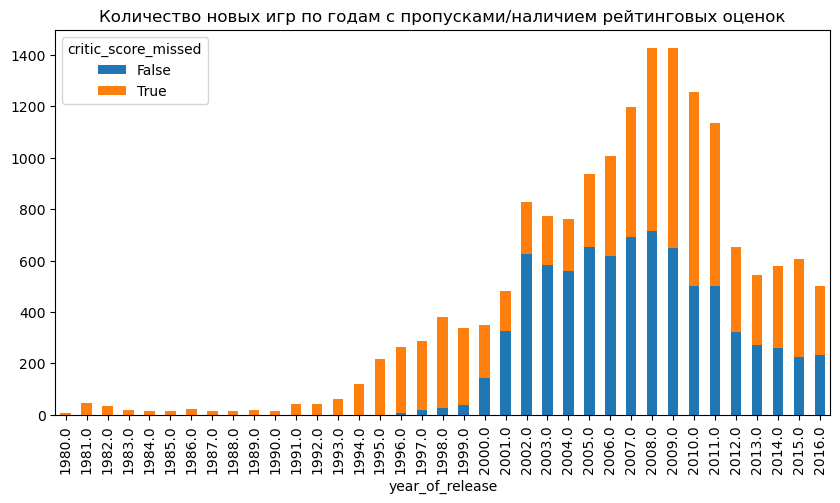

In [9]:
# отразим на графике
(
good_data
.join(good_data.isna()['critic_score'], lsuffix='_l', rsuffix='_missed')
.pivot_table(index='year_of_release', columns=['critic_score_missed'], dropna=False, aggfunc='count')['name']
.plot(kind='bar', figsize=(10,5), stacked=True, title='Количество новых игр по годам с пропусками/наличием рейтинговых оценок')
)

plt.show()

На графике видно, что до начала 2000 года почти по всем играм отсутствует информация по оценке критиков и игроков. Наиболее вероятно, что до 2000 года такая информация просто систематически не собиралась, возрастные рейтинги не проставлялись. После 2000 года картина резко меняется и доля игр с наличием ретинговых оценок резко повышается. К 2016 году около половины ежегодно выпускаемых игр получают возрастной рейтинг и оценку пользователей. Есть еще факторы, влияющие на появление пропусков в данных, помимо года выпуска игры. 

Оценки в `critic_score` и `user_score` индивидуальный и персональный показатель каждой отдельно взятой игры, что заполнить его нечем. Пропуски <mark style="background:gold">оставляем</mark>.

Пропуски в категориальной переменной `rating` <mark style="background:lightgreen">заполним</mark> как 'n/a'.

In [10]:
good_data['rating'] = good_data['rating'].fillna('n/a')
good_data['rating'].value_counts()

n/a     6676
E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

Видно несколько выбивающихся рейтингов с небольшим количеством упоминаний. Посмотрим на них подробнее:

- "EC" ("Early childhood") — "Для детей младшего возраста" - актуальный рейтинг и аналогов ему нет. Оставим как есть.
- "K-A" ("Kids to Adults") - устаревшая аббревиатура. Вместо нее применяется «E» («Everyone») — «Для всех». Заменим K-A на E
- "AO" ("Adults Only 18+") — "Только для взрослых" - актуальный рейтинг и аналогов ему нет. Оставим как есть.
- "RP" ("Rating Pending") — "Рейтинг ожидается". Фактически это эквивалент n/a

Проведем корректировку:

In [11]:
good_data.loc[good_data['rating'] == 'K-A', 'rating'] = 'E'
good_data.loc[good_data['rating'] == 'RP', 'rating'] = 'n/a'
good_data['rating'].value_counts()

n/a     6677
E       3924
T       2905
M       1536
E10+    1393
EC         8
AO         1
Name: rating, dtype: int64

---
**Изменение формата данных**

    Column           Non-Null Count  Dtype        Новый формат  Причина замены 
---  ------           --------------  -----       ------------  --------------
    0   name             16713 non-null  object   не меняем
    1   platform         16715 non-null  object   не меняем
    2   year_of_release  16446 non-null  float64  int32         год выпуска - целочисленный параметр
    3   genre            16713 non-null  object   не меняем
    4   na_sales         16715 non-null  float64  float32       оптимизация использования памяти
    5   eu_sales         16715 non-null  float64  float32       оптимизация использования памяти
    6   jp_sales         16715 non-null  float64  float32       оптимизация использования памяти
    7   other_sales      16715 non-null  float64  float32       оптимизация использования памяти
    8   critic_score     8137 non-null   float64  float32       оптимизация использования памяти
    9   user_score       10014 non-null  object   float32       оценка пользователя - числовое значение
    10  rating           9949 non-null   object   не меняем

In [12]:
# user_score - проверим, почему формат данных при импорте установлен как object
good_data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В поле `user_score` часть значений проставлена как `tbd` (to be defined), т.е. на момент формирования выборки еще не оценка не определена. Заменим 'tbd' на NaN

In [13]:
good_data['user_score'].replace('tbd', np.NaN, inplace=True)

In [14]:
good_data['year_of_release'] = good_data['year_of_release'].astype('int32')

# поменяем формат в цикле
for col in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score']:
    good_data[col] = good_data[col].astype('float32') 

# отобразим форматы данных после корректировки
good_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float32
 5   eu_sales         16444 non-null  float32
 6   jp_sales         16444 non-null  float32
 7   other_sales      16444 non-null  float32
 8   critic_score     7983 non-null   float32
 9   user_score       7463 non-null   float32
 10  rating           16444 non-null  object 
dtypes: float32(6), int32(1), object(4)
memory usage: 1.6+ MB


---
**Проверка на дубликаты**

In [15]:
good_data.duplicated().sum()

0

In [16]:
good_data['platform'].value_counts()

PS2     2127
DS      2121
PS3     1306
Wii     1286
X360    1232
PSP     1193
PS      1190
PC       957
GBA      811
XB       803
GC       542
3DS      512
PSV      429
PS4      392
N64      316
XOne     247
SNES     239
SAT      173
WiiU     147
2600     116
NES       98
GB        97
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, dtype: int64

In [17]:
good_data['genre'].value_counts()

Action          3307
Sports          2306
Misc            1721
Role-Playing    1481
Shooter         1296
Adventure       1293
Racing          1226
Platform         878
Simulation       857
Fighting         837
Strategy         673
Puzzle           569
Name: genre, dtype: int64

In [18]:
good_data['rating'].value_counts()

n/a     6677
E       3924
T       2905
M       1536
E10+    1393
EC         8
AO         1
Name: rating, dtype: int64

Неявных дубликатов не обнаружено

---
**Добавление столбцов**

In [19]:
# добавим столбец с полными продажами по миру
good_data['total_sales'] = (
    good_data['na_sales'] +
    good_data['eu_sales'] +
    good_data['jp_sales'] +
    good_data['other_sales']
)

---
**Проверка**

In [20]:
# таблица с пропусками по столбцам
display(
 pd.concat([
     good_data.isna().sum(), 
     good_data.isna().mean()*100
 ],axis=1).rename(columns=({0:'empties', 1:'empties%', 2:'median'}))
)

# сравним с изначальными данными
print('Количество строк в изначальной выборке:', len(raw_data))
print('Количество строк в финальной выборке:', len(good_data))
print('Удалено строк:', len(raw_data) - len(good_data),  round(100 -len(good_data) / len(raw_data) * 100,1), '%')

,empties,empties%
name,0,0.00
platform,0,0.00
year_of_release,0,0.00
genre,0,0.00
na_sales,0,0.00
eu_sales,0,0.00
jp_sales,0,0.00
other_sales,0,0.00
critic_score,8461,51.45
user_score,8981,54.62


Количество строк в изначальной выборке: 16715
Количество строк в финальной выборке: 16444
Удалено строк: 271 1.6 %


---
## Промежуточные выводы

- Импорт: Данные импортированы без проблем, датафрейм содержит более 16 тысяч записей, структра данных понятна.

- Пропуски: по основным полям с информацией по играм пропусков практически не наблюдалось, однако в полях с рейтинговыми оценками (рейтинг пользователей, критиков, возрастная категория) около половины данных пропущены. Для слишком старых игр (до 2000 года) наиболее вероятная причина пропусков - отсутствие систематизированного сбора оценок. После 2000 года около половины игр имеют данные по рейтингам, соотвественно есть еще какие-то причины появления пропусков. Поскольку эти пропуска составляют значительный процент от выборки и при этом рейтинг это индивидуальный показатель для каждой игры, принято решение оставить пропуски без заполнения.

- Дубликаты: дубликаты не обнаружены

- Форматы данных полей: формат данных некоторых полей был пересмотрен либо для бОльшего соответствия типу хранимых значений либо для сокращения использования памяти датафреймом.

- Добавление полей: добавлено вычисляемое поле с суммарными продажами по миру `total_sales`

---

# Исследовательский анализ данных

**Объем выпуска игр по годам**

Задание: `Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?`

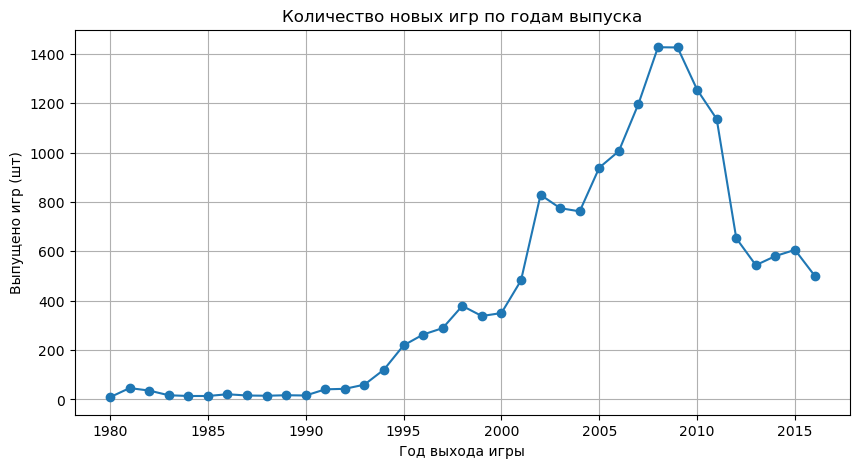

In [21]:
# график количества игр по годам выпуска
ax = (
good_data
.pivot_table(index='year_of_release', dropna=False, aggfunc='count')['name']
.plot(kind='line', figsize=(10,5),style='o-', grid=True, stacked=True, title='Количество новых игр по годам выпуска')
)

#  Добавляем подписи к осям:
ax.set_xlabel('Год выхода игры')
ax.set_ylabel('Выпущено игр (шт)')

plt.show()

Видно, что на заре игростроя, с 1980 по 1994 , каждый год выпускалось незначительное количество игр. Начиная с 1995 ежегодный объем превысил 200 игр. с 1995 до 2009 года шел бурный рост количества выпускаемых игр,вплоть до 1400 игр/год. Который впоследствии сменился падением объемов выпуска, с выходом на плато 400-600 игр в год начиная с 2012 года. 

Будем считать, что **актуальный период для индустрии игр составляет 2 года, в нашем случае 2015-2016**. Более ранние периоды явно приходятся на другую рыночную ситуацию (бурный рост, затем такое же бурное падение), потому нет смысла брать их в расчет.


---
**Продажи по платформам по годам**

Задание: `Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?`

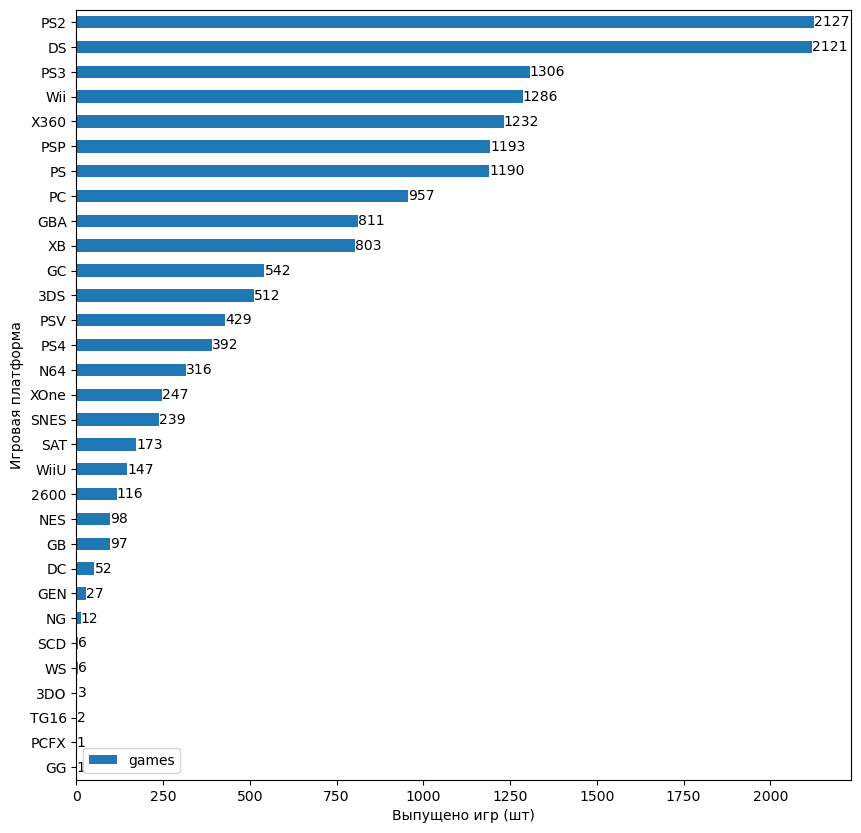

In [22]:
# топ-10 самых успешных платформ за всю историю
platform_games = good_data.pivot_table(index='platform', aggfunc='count')['name'].reset_index().set_index('platform')
platform_games.rename(columns={'name':'games'}, inplace = True )

# отобразим графиком
ax = platform_games.sort_values(by='games').plot(kind='barh', figsize=(10,10))
ax.bar_label(ax.containers[0])

#  Добавляем подписи к осям:
ax.set_xlabel('Выпущено игр (шт)')
ax.set_ylabel('Игровая платформа')

plt.show()

Выход новых игр по Топ-10 платформам


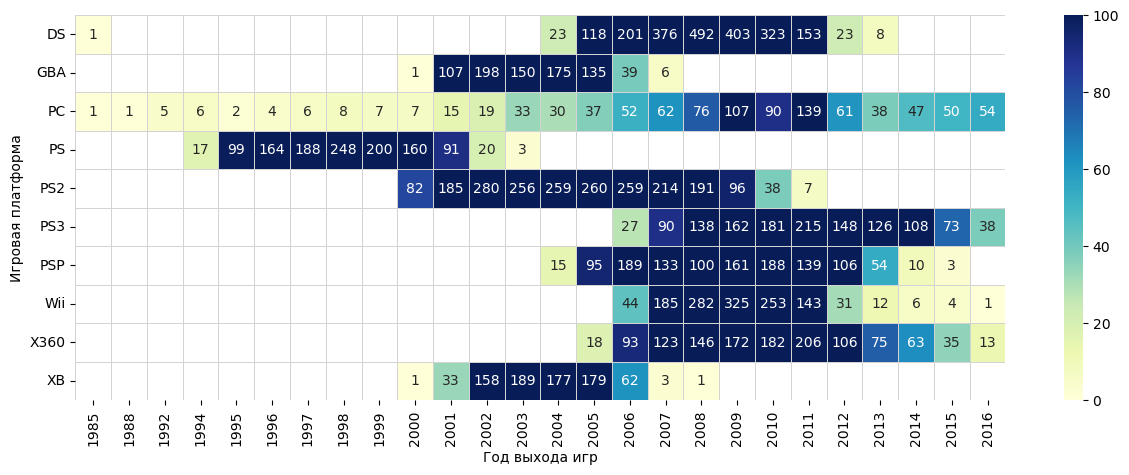

In [23]:
# отобразим график выхода игр по годам для топ-10 платформ
platforms_top_10 = platform_games.sort_values(by='games', ascending=False).head(10).index.values.tolist()

# хитмап
print('Выход новых игр по Топ-10 платформам')
plt.figure(figsize=(15,5))
ax = sns.heatmap(
    good_data
    .query('platform in @platforms_top_10')
    .pivot_table(index='platform', columns='year_of_release', values='name', aggfunc='count'),
    linewidths=.5,
    linecolor = 'lightgray',
    annot=True,
    vmax=100,
    vmin=0,
    fmt='n',
    cmap="YlGnBu" 
    )
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 

#  Добавляем подписи к осям:
ax.set_xlabel('Год выхода игр')
ax.set_ylabel('Игровая платформа')

plt.show()

# один общий график
# (
# good_data
#     .query('platform in @platforms_top_10')
#     .pivot_table(index='platform', columns='year_of_release', values='name', aggfunc='count')
#     .T
#     .plot(kind='area', alpha=0.5,   figsize=(15,5))
# )     

Будем считать год активным для игровой платформы, если за год выпускается 100 и более игр. 
Если применить это правило для Топ-10 игровых платформ за всю историю, то прослеживается **характерный срок жизни платформы в 5-8 лет**.
Исключение составляет платформа PC , с большим количеством суммарно выпущенных игр, однако более плавно распределенных по многим годам, с редкими превышениями уровня 100 игр/год

---
**Анализ актуального периода**

Задание: `Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
Не учитывайте в работе данные за предыдущие годы.
Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.`

Ранее было установлено, что актуальный период считаем с 2015 года. Проведем анализ продаж по платформам за период 2015-2016 год:

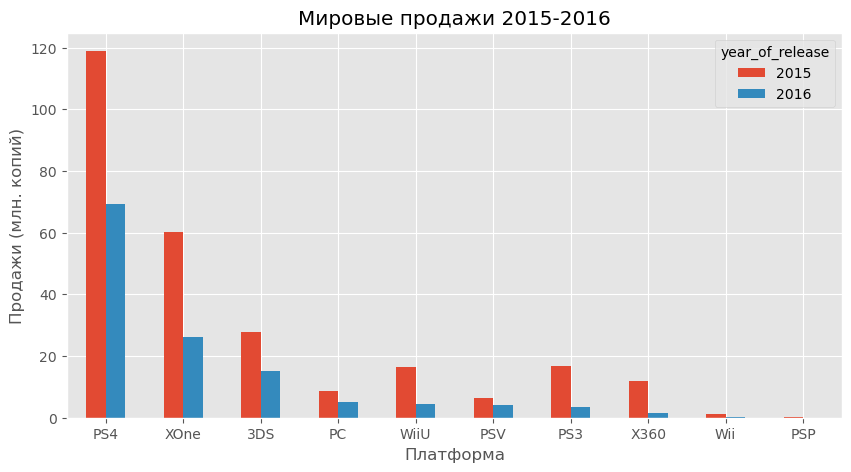

In [24]:
# перенесем актуальные данные в отдельный датафрейм
actual_data = good_data.query('year_of_release >= 2015')

# таблица со сводными данными по мировым продажам
actual_summary = actual_data.pivot_table(
    index='platform', 
    columns='year_of_release', 
    values='total_sales', aggfunc='sum') 
actual_summary.fillna(0, inplace=True)
 
# отобразим на графике
mpl.style.use('ggplot')
ax = (
    actual_summary
    .sort_values(by=2016, ascending=False)
    .plot(kind='bar', stacked=False, figsize=(10,5), title='Мировые продажи 2015-2016')
)

#  Добавляем подписи к осям:
ax.set_xlabel('Платформа')
ax.set_ylabel('Продажи (млн. копий)')
plt.xticks(rotation=0, horizontalalignment="center")

plt.show()

In [25]:
# функция для определения года начала продаж
def get_sales_start(platform):
    return good_data.query('platform == @platform')['year_of_release'].min()


# сформируем аналитическую таблицу

# сортируем таблицу по объему продаж в 2016
actual_summary = actual_summary.sort_values(by=2016, ascending=False)

# добавим строку Total с итогами
actual_summary.loc['Total']= actual_summary.sum()

# добавим расчетные столбцы
actual_summary['sales_delta'] = actual_summary[2016] - actual_summary[2015] # абсолютное изменение объема продаж
actual_summary['share_2015'] = actual_summary[2015] / actual_summary.query('platform != "Total"')[2015].sum()  # доля рынка за 1-ю половину
actual_summary['share_2016'] = actual_summary[2016] / actual_summary.query('platform != "Total"')[2016].sum() # доля рынка за 2-ю половину
actual_summary['share_delta%'] = actual_summary['share_2016'] / actual_summary['share_2015'] - 1 # процентное изменение доли рынка

# год начала продаж
actual_summary['sales_start'] = actual_summary.index  
actual_summary['sales_start'] = actual_summary['sales_start'].apply( get_sales_start )

# подсветим ячейки условным форматированием
(
    actual_summary.style.applymap(
    lambda x: 'color : green' if x>=0 else'color : red ' , 
    subset=pd.IndexSlice[:, ['share_delta%']]).format(
        formatter={
            2015:"{:.1f}", 
            2016:"{:.1f}", 
            'sales_start':"{:.0f}",
            'sales_delta':"{:.1f}",
            'share_2015':"{:.1%}",
            'share_2016':"{:.1%}",
            'share_delta%':"{:.0%}"})
)
 

year_of_release,2015,2016,sales_delta,share_2015,share_2016,share_delta%,sales_start
platform,,,,,,,
PS4,118.9,69.2,-49.7,44.4%,53.3%,20%,2013
XOne,60.1,26.1,-34.0,22.4%,20.1%,-10%,2013
3DS,27.8,15.1,-12.6,10.4%,11.7%,12%,2011
PC,8.5,5.2,-3.3,3.2%,4.0%,27%,1985
WiiU,16.4,4.6,-11.8,6.1%,3.5%,-42%,2012
PSV,6.2,4.2,-2.0,2.3%,3.3%,40%,2011
PS3,16.8,3.6,-13.2,6.3%,2.8%,-56%,2006
X360,12.0,1.5,-10.4,4.5%,1.2%,-74%,2005
Wii,1.1,0.2,-1.0,0.4%,0.1%,-67%,2006


За 2 года актуального периода заметно значительное падение рынка продаж игр - в 2016 году продано вдвое меньше, чем в 2015. Однако, это может быть связано с неполными данными за 2016 год. 

Для вынесения рекомендаций воспользуемся оценкой доли рынка и динамики ее изменения. 

В первую очередь отметим платформы с большой рыночной долей  в 2016 - `PS4`, `XOne` и `3DS`. Первые две - относительно свежие, старт продаж был в 2013 году, к 2017 они еще останутся актуальными платформами. `3DS` на рынке с 2011 года, в 2017 она может стать неактуальной, если выйдет обновленная платформа. 

Также выделим платформы с растущей долей рынка - это `PC` и `PSVita`. Первая представлена на рынке с 1985 года и все еще в строю - нет оснований полагать, что продажи резко прекратятся в 2017 году. У `PSV` нет такой долгой истории, консоль вышла в 2011 году, к 2017 году ей будет уже 6 лет, что добавляет рисков стать неактуальной в 2017. 

`PS4`, `XOne`, `3DS` **однозначно можно отнести к потенциально прибыльным платформам в 2017 году**.
 
Также **стоит обратить внимание на** `PC` и `PSV` - они показали рост доли рынка в 2016 году, платформа `PC` при этом уже много лет на рынке и срок жизни 5-8 лет для нее не применим.

---
**Ящик с усами**

Задание: `Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.`

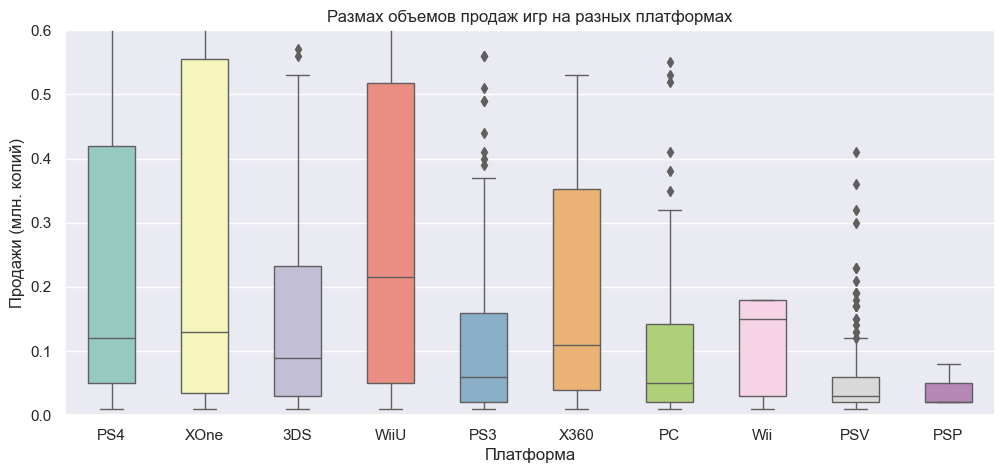

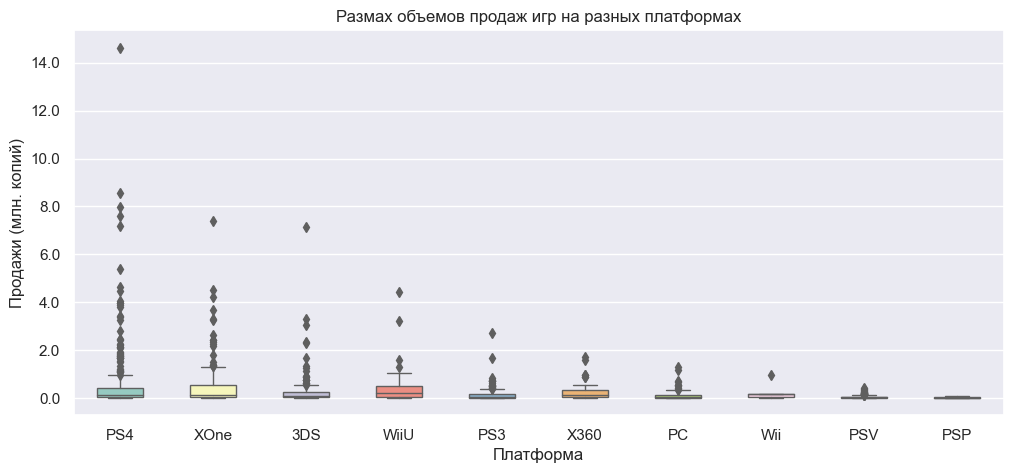

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
WiiU,42.00,0.50,0.85,0.01,0.05,0.21,0.52,4.44
Wii,5.00,0.26,0.39,0.01,0.03,0.15,0.18,0.95
XOne,167.00,0.52,0.97,0.01,0.03,0.13,0.56,7.39
PS4,301.00,0.63,1.46,0.01,0.05,0.12,0.42,14.63
X360,48.00,0.28,0.38,0.01,0.04,0.11,0.35,1.70
3DS,132.00,0.33,0.80,0.01,0.03,0.09,0.23,7.14
PS3,111.00,0.18,0.34,0.01,0.02,0.06,0.16,2.70
PC,104.00,0.13,0.21,0.01,0.02,0.05,0.14,1.28
PSV,195.00,0.05,0.06,0.01,0.02,0.03,0.06,0.41


In [26]:
#good_data.boxplot(column = 'total_sales', by='platform', figsize=(15,5))

sns.set(rc={'figure.figsize':(12,5)}) # установим размер графиков

#построим диаграмму
plt.ylim([0,0.6])
ax = sns.boxplot(x='platform',y='total_sales', data=actual_data, width=0.5, palette="Set3", linewidth=1)
ax.set_title('Размах объемов продаж игр на разных платформах')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1f}'))
ax.set_xlabel('Платформа')
ax.set_ylabel('Продажи (млн. копий)')
plt.show()

#построим диаграмму в масштабе 100%
ax = sns.boxplot(x='platform', y='total_sales', data=actual_data, width=0.5, palette="Set3", linewidth=1)
ax.set_title('Размах объемов продаж игр на разных платформах')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1f}'))
ax.set_xlabel('Платформа')
ax.set_ylabel('Продажи (млн. копий)')
plt.show()

# отобразим таблицу со статистическими данными
actual_data.groupby(by='platform')['total_sales'].describe().sort_values(by='50%', ascending=False)

График распределения объемов продаж игр по различным платформам показывает следующее:
- Наиболее широкими тиражами расходятся игра на платформе WiiU - медиана 210 тысяч копий.
- Игры на платформы Wii, XOne, PS4, X360 продались в 2015-2016 годах по 110-150 тысяч копий
- При этом по многим платформам встречаются значительные выбросы, вплоть до 14.6 миллиона проданных копий у одной из игр PS4

---
**Влияние отзывов на продажи**

Задание: `Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
Соотнесите выводы с продажами игр на других платформах.`

Для проверки корреляции между отзывами и продажами возьмем игры для самой популярной платформы последнего времени - `PS4`. Построим диаграмму рассеяния и оценим корреляцию.

In [27]:
# функция для единообразоного отображения корреляции между продажами и заданным столбцом для требуемой платформы
def show_total_sales_corr(platform, column):
    print('Корреляция столбца', column,'с объемом продаж для', platform)
    
    # график зависимости между продажами и отзывом критиков
    ax = (
        actual_data
        .query('platform == @platform')
        .plot(
            kind='scatter', 
            x=column, 
            y='total_sales', 
            grid=True, 
            alpha=0.3, 
            title='Зависимость total_sales от ' + column + ' для платформы ' + platform)
    )
    ax.set_xlabel(column)
    ax.set_ylabel('Продажи (млн. копий)')
    plt.show()
    
    # корреляция
    display(actual_data.query('platform == @platform')[[column,'total_sales']].corr())

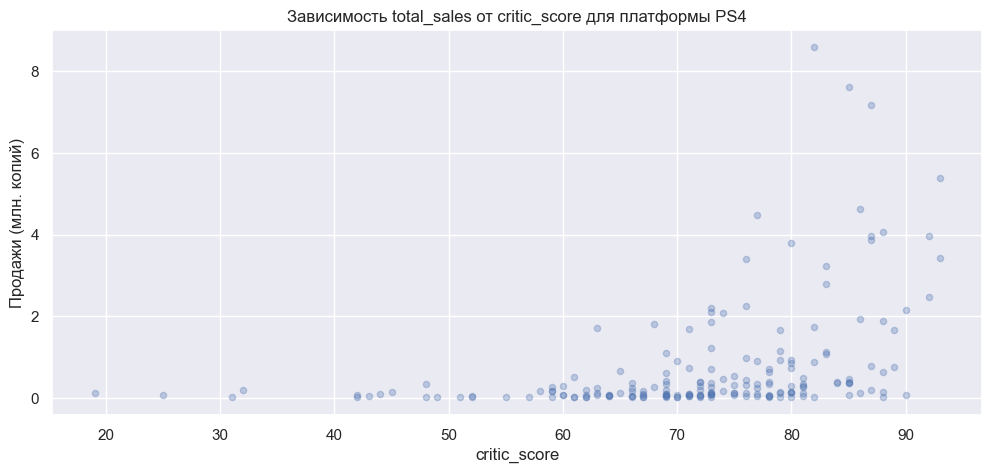

,critic_score,total_sales
critic_score,1.00,0.39
total_sales,0.39,1.00


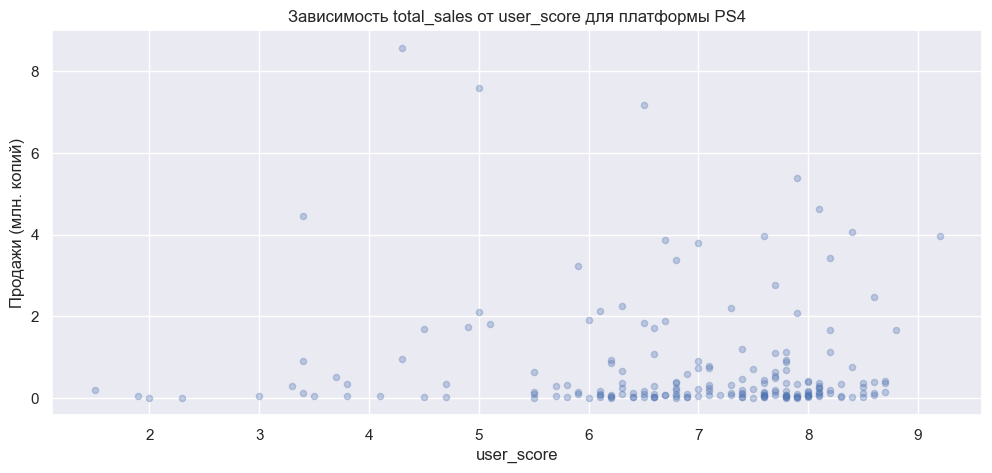

,user_score,total_sales
user_score,1.00,-0.06
total_sales,-0.06,1.00


In [28]:
%%capture --no-display
show_total_sales_corr('PS4','critic_score')
show_total_sales_corr('PS4','user_score')

 Результат удивляет. 
- Продажи игр на PS4 никак не зависят от оценок пользователей, корреляция нулевая.
- Мнения критиков гораздо больше соотносятся с объемами продаж - корреляция уже 0.41
- Сам по себе коэффициент 0.39 не означает сильную зависимость, т.е. полагаться на отзывы для прогноза объема продаж не стоит.
- Также нельзя сделать вывод, что первично - оценка влияет на продажи, или продажи влияют на оценку (через рекламные бюджеты), основываясь только на коэффициенте корреляции, нельзя. 

Проверим выводы на паре других платформ - `XOne` и `WiiU`

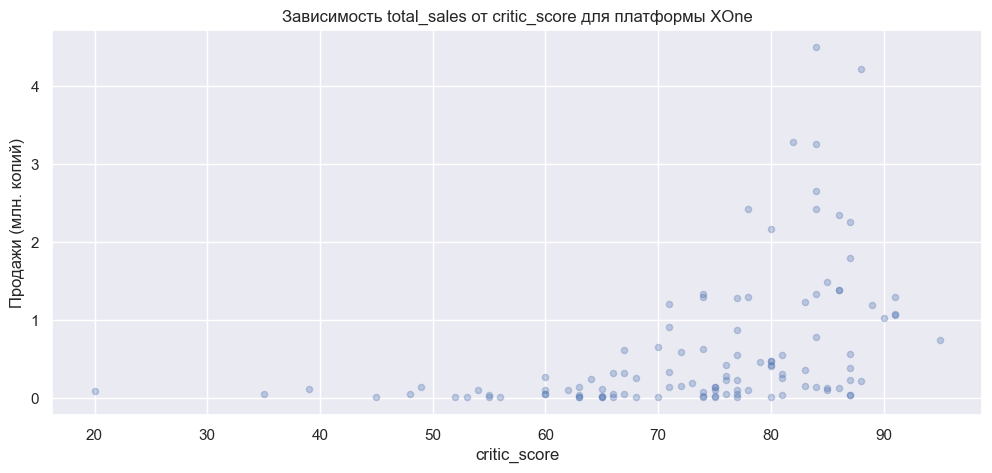

,critic_score,total_sales
critic_score,1.00,0.43
total_sales,0.43,1.00


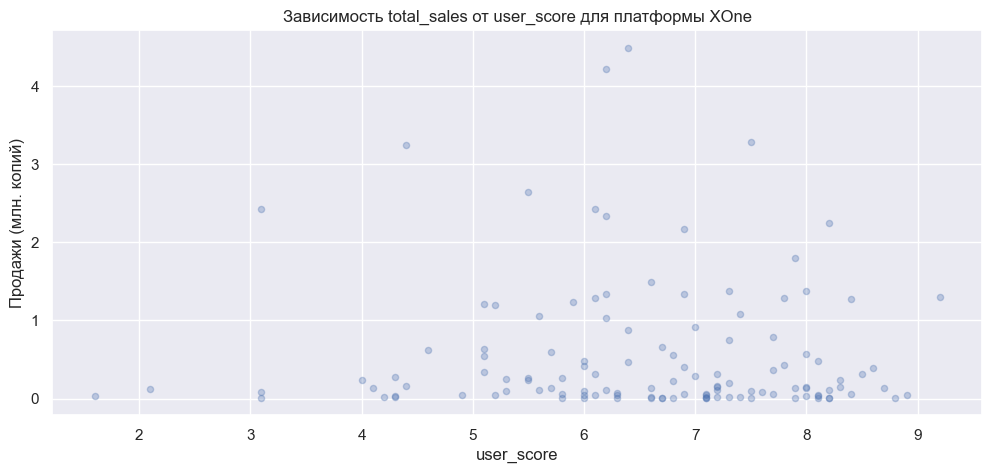

,user_score,total_sales
user_score,1.00,-0.04
total_sales,-0.04,1.00


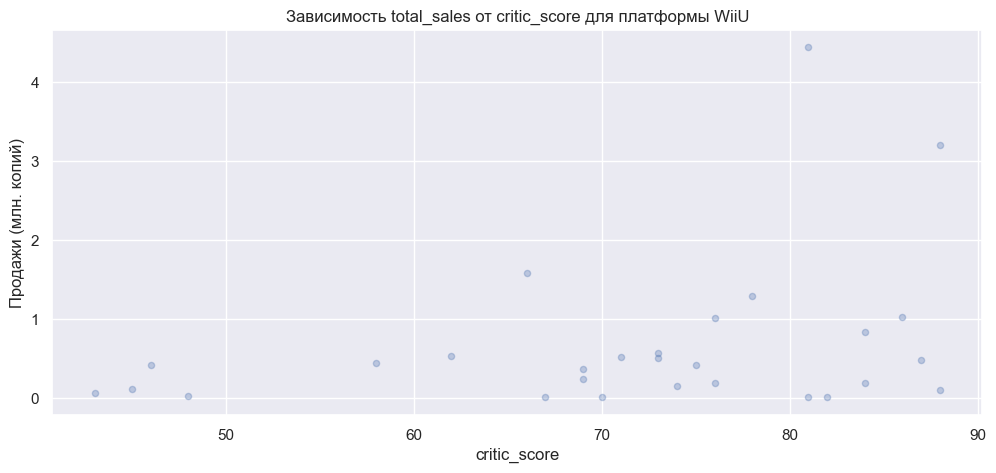

,critic_score,total_sales
critic_score,1.00,0.32
total_sales,0.32,1.00


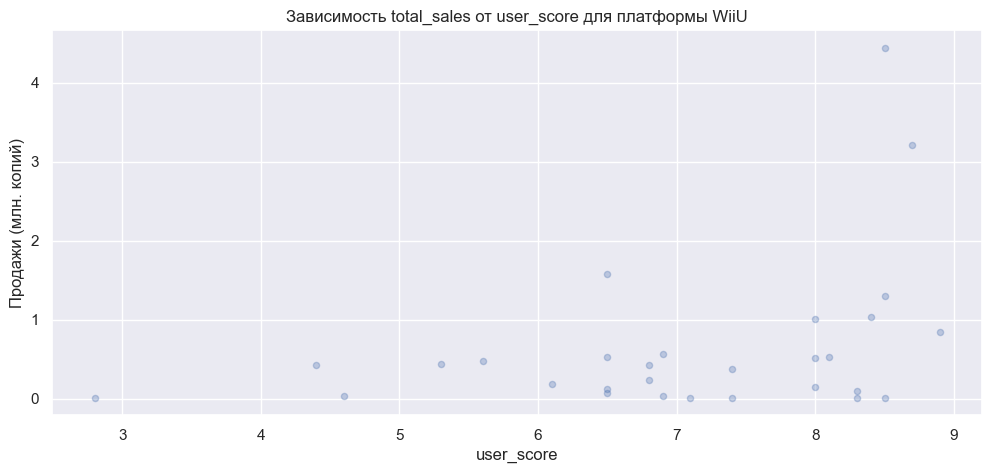

,user_score,total_sales
user_score,1.00,0.36
total_sales,0.36,1.00


In [29]:
%%capture --no-display
show_total_sales_corr('XOne','critic_score')
show_total_sales_corr('XOne','user_score')

show_total_sales_corr('WiiU','critic_score')
show_total_sales_corr('WiiU','user_score')

В целом картина для XOne сходится с показателями PS4

Для WiiU корреляция с объемом продаж для оценок пользователей и оценок критиков близка - 0.36 и  0.32 соответственно. 

---
**Прибыльность жанров**

Задание: `Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?`

In [30]:
gende_data = actual_data.pivot_table(index='genre', values='total_sales', aggfunc=['count','sum','median'])
#display(gende_data)
  
print('\nНаиболее продаваемые жанры:')
column = ('sum','total_sales')
display(gende_data.sort_values(by=column, ascending=False).head(3)[column].reset_index())

print('\nНаименее продаваемые жанры:')
column = ('sum','total_sales')
display(gende_data.sort_values(by=column, ascending=True).head(3)[column].reset_index())

#print('\nТоп-3 жанра с самыми продаваемыми играми:')
#column = ('median','total_sales')
#display(gende_data.sort_values(by=column, ascending=False).head(3)[column].reset_index())


Наиболее продаваемые жанры:


,genre,sum
,,total_sales
0,Shooter,105.73
1,Action,102.13
2,Sports,64.33



Наименее продаваемые жанры:


,genre,sum
,,total_sales
0,Puzzle,0.72
1,Strategy,2.98
2,Simulation,7.55


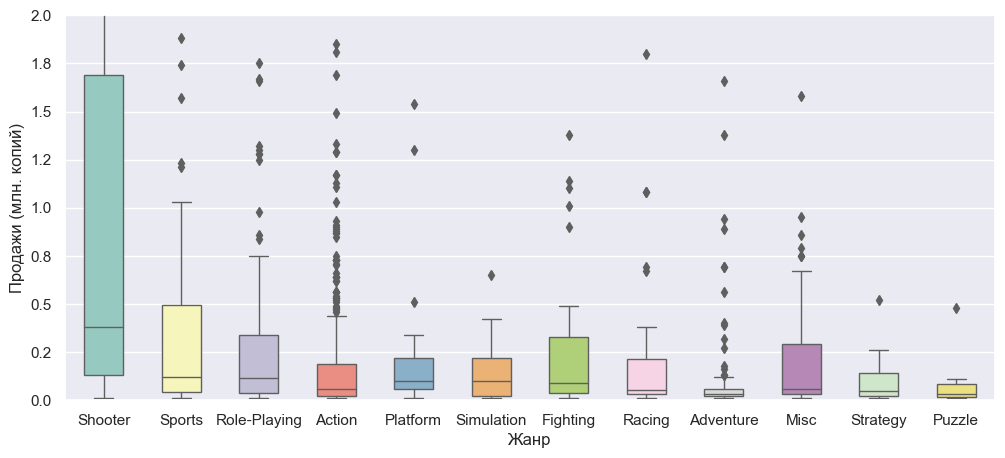

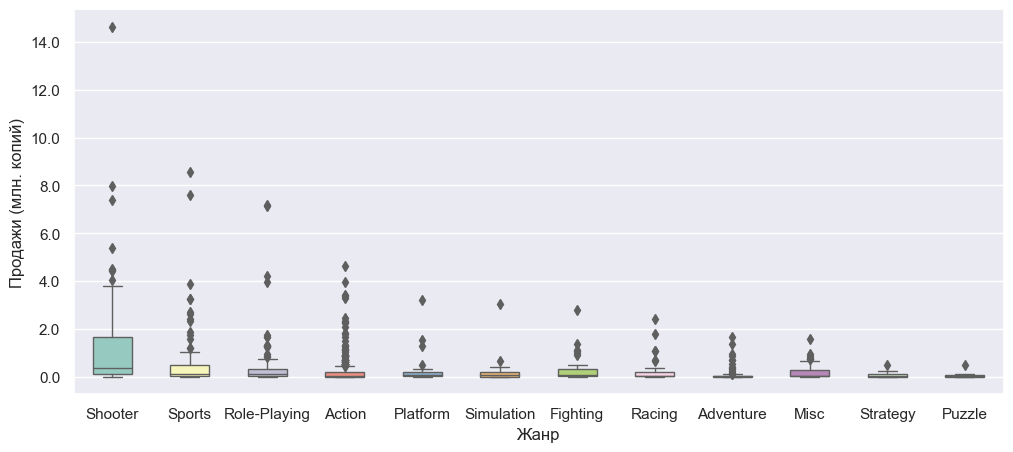

In [31]:
#построим диаграмму размаха
plt.ylim([0,2])
ax = sns.boxplot(x='genre', y='total_sales', data=actual_data, width=0.5, palette="Set3", linewidth=1 )
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1f}'))
ax.set_xlabel('Жанр')
ax.set_ylabel('Продажи (млн. копий)')
plt.show()

#построим диаграмму в масштабе 100%
ax = sns.boxplot(x='genre', y='total_sales', data=actual_data, width=0.5, palette="Set3", linewidth=1)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1f}'))
ax.set_xlabel('Жанр')
ax.set_ylabel('Продажи (млн. копий)')
plt.show()

Самые прибыльные жанры - `Action`, `Shooter` и `Role-Playing`

Самые плохо продаваемые жанры - `Puzzle`, `Strategy` и `Adventure`

Разница по объему продаж между самым популярным `Action` и самым непопулярным `Puzzle` - почти в 100 раз.

Игры жанра `Shooter` резко выделяются на фоне остальных высоким медианным значением объема продаж и самым высоким потенциальным доходом. При этом 75% игр этого жанра продались тиражом более 100 тысяч копий. Жанр `Shooter` можно признать самым успешным среди остальных.

---
## Промежуточные выводы:

В рамках исследования были установлено следующее:

- На заре индустрии, с 1980 по 1994 годы выпускалось незначительное количество игр
- Бурный рост наблюдался в период с 1995 по 2009 годы, доросший вплоть до 1400 игр/год
- Значительное падение было с 2009 до 2012 года, с выходом на плато в 400-600 игр в год, сохраняющимся в периоде 2012-2016
- Период 2015-2016 года можно считать актуальным для прогнозирования ситуации на рынке в 2017 году
- Средний срок активной жизни (ежегодно - более 100 новых игр) игровой платформы составляет 5-8 лет
- PS4, XOne, 3DS - наиболее перспективные консоли по объему продаж новых игр в 2017 году
- PC и PSV также можно отнести к потенциально интересным на 2017 год
- Самые хорошо продаваемые игры выходили на WiiU - медиана 210 тысяч копий
- Игры на прочих ходовых платформах (Wii, XOne, PS4, X360 ) обычно продаются по 110-150 тысяч копий
- Периодически встречаются игры-рекордсмены с продажами до 14.6 миллиона копий в рамках одной платформы (PS4)
- Оценки пользователей не отражают объемы продаж, опираться на такие оценки не стоит
- Оценки критиков гораздо более надежны, но все же не достаточно (корреляция 0.41), чтобы однозначно спрогнозировать успех той или иной игры

# Портрет пользователя каждого региона

Задание:`Определите для пользователя каждого региона (NA, EU, JP):
Самые популярные платформы (топ-5). Опишите различия в долях продаж.
Самые популярные жанры (топ-5). Поясните разницу.`

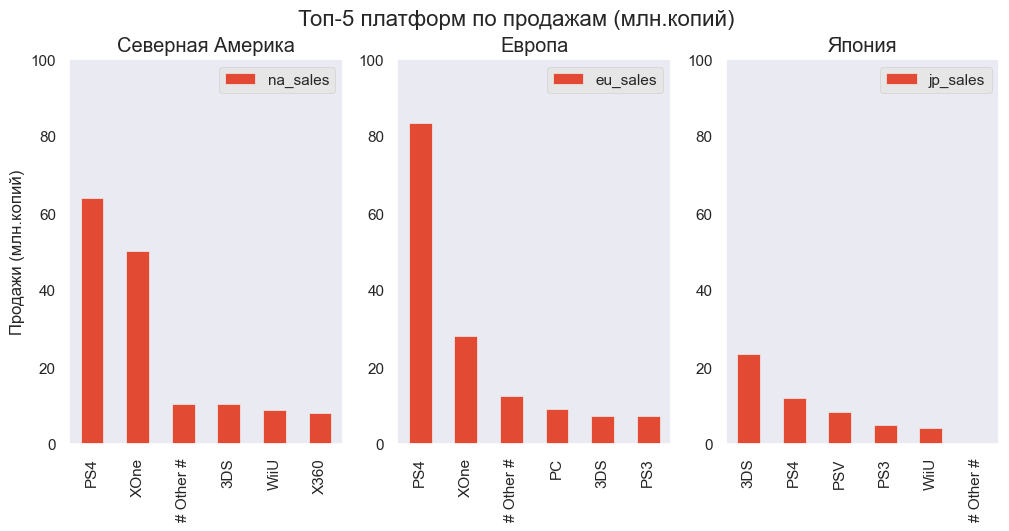

In [32]:
# регистрируем блок из 3х графиков
fig, axes = plt.subplots(nrows=1, ncols=3)

mpl.style.use('ggplot') # добавим стиля

fig.suptitle(' Топ-5 платформ по продажам (млн.копий)  ', fontsize=16) # общий заголовок

# добавляем данные по Северной Америке
_subdata = actual_data.groupby(by='platform')['na_sales'].sum().sort_values(ascending=False).reset_index() # группируем данные для графика
_subdata.loc[5:,'platform'] = '# Other #' # переименовываем все платформы вне ТОП-5 к 'Other'
_subdata = _subdata.groupby('platform').sum().sort_values('na_sales',  ascending=False) # еще раз группируем чтобы схлопнуть Other
ax = _subdata.plot(ax=axes[0], kind='bar', title='Северная Америка', grid=False, ylim=(0,100)) # формируем график
ax.set_xlabel('')
ax.set_ylabel('Продажи (млн.копий)')
#display(_subdata)


# добавляем данные по Европе
_subdata = actual_data.groupby(by='platform')['eu_sales'].sum().sort_values(ascending=False).reset_index()
_subdata.loc[5:,'platform'] = '# Other #'
_subdata = _subdata.groupby('platform').sum().sort_values('eu_sales',  ascending=False) 
ax = _subdata.plot(ax=axes[1], kind='bar', title='Европа',   grid=False, ylim=(0,100))
ax.set_xlabel('')
ax.set_ylabel('')
#display(_subdata)


# добавляем данные по Японии
_subdata = actual_data.groupby(by='platform')['jp_sales'].sum().sort_values(ascending=False).reset_index()
_subdata.loc[5:,'platform'] = '# Other #'
_subdata = _subdata.groupby('platform').sum().sort_values('jp_sales',  ascending=False) 
ax = _subdata.plot(ax=axes[2], kind='bar', title='Япония', grid=True, ylim=(0,100))
ax.set_xlabel('')
ax.set_ylabel('')
#display(_subdata)
 
plt.grid()
plt.show()

**Рынок NA** - На американском рынке самые популярные платформы - стационарный игровые консоли, лидирует консоль от Sony - PS4. Также очень популярна консоль от Microsoft - XOne. Флагман от Sony может похвастаться более высокими продажами игр, по сравнению с последней консолью от Microsoft. Также значительную популярность приобрели мобильные консоли от Nintendo- 3DS и WiiU.

**Рынок EU** - На рынке Европы очень популярна PS4. Американские XBox гораздо менее распространены. Также в ТОП попал PC, чего не просматривается на других рынках. 

**Рынок JP** - На японском рынке весьма сильно распространены мобильные консоли - лидирует 3DS, в топ-5 также попали PSVita и WiiU. Из стационарных консолей популярны консоли от Sony - PS3 и PS4. Консоли от Microsoft не популярны на японском рынке, равно как и PC.

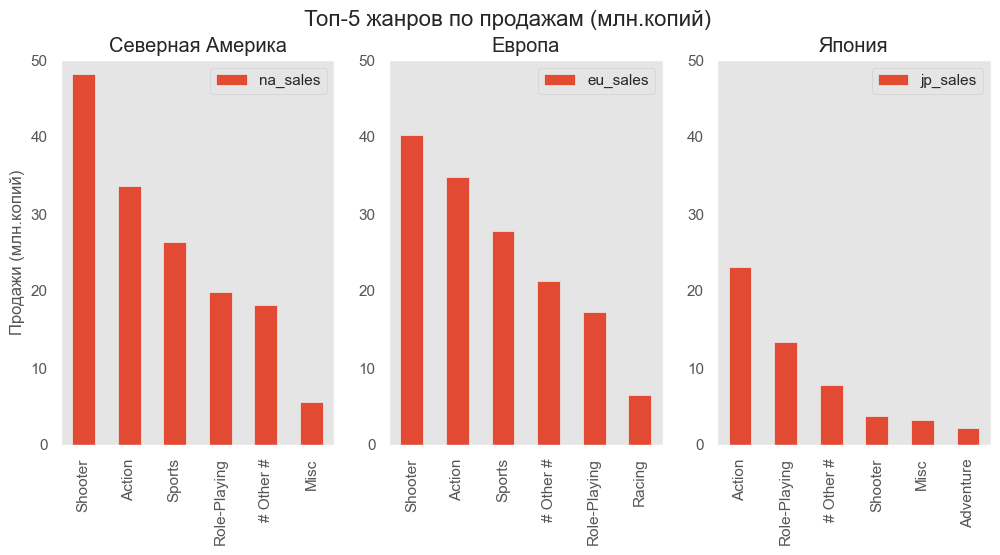

In [33]:
#print('Топ-5 популярных жанров в Северной Америке за 2015-2016 годы')
#display(actual_data.groupby(by='genre')['na_sales'].sum().sort_values(ascending=False).head().reset_index())

#print('Топ-5 популярных жанров в Европе за 2015-2016 годы')
#display(actual_data.groupby(by='genre')['eu_sales'].sum().sort_values(ascending=False).head().reset_index())

#print('Топ-5 популярных жанров в Японии за 2015-2016 годы')
#display(actual_data.groupby(by='genre')['jp_sales'].sum().sort_values(ascending=False).head().reset_index())

# регистрируем блок из 3х графиков
fig, axes = plt.subplots(nrows=1, ncols=3)

mpl.style.use('ggplot') # добавим стиля

fig.suptitle(' Топ-5 жанров по продажам (млн.копий)  ', fontsize=16) # общий заголовок

# добавляем данные по Северной Америке
_subdata = actual_data.groupby(by='genre')['na_sales'].sum().sort_values(ascending=False).reset_index() # группируем данные для графика
_subdata.loc[5:,'genre'] = '# Other #' # переименовываем все платформы вне ТОП-5 к 'Other'
_subdata = _subdata.groupby('genre').sum().sort_values('na_sales',  ascending=False) # еще раз группируем чтобы схлопнуть Other
ax = _subdata.plot(ax=axes[0], kind='bar', title='Северная Америка', grid=False, ylim=(0,50)) # формируем график
ax.set_xlabel('')
ax.set_ylabel('Продажи (млн.копий)')
#display(_subdata)


# добавляем данные по Европе
_subdata = actual_data.groupby(by='genre')['eu_sales'].sum().sort_values(ascending=False).reset_index()
_subdata.loc[5:,'genre'] = '# Other #'
_subdata = _subdata.groupby('genre').sum().sort_values('eu_sales',  ascending=False) 
ax = _subdata.plot(ax=axes[1], kind='bar', title='Европа',   grid=False, ylim=(0,50))
ax.set_xlabel('')
ax.set_ylabel('')
#display(_subdata)


# добавляем данные по Японии
_subdata = actual_data.groupby(by='genre')['jp_sales'].sum().sort_values(ascending=False).reset_index()
_subdata.loc[5:,'genre'] = '# Other #'
_subdata = _subdata.groupby('genre').sum().sort_values('jp_sales',  ascending=False) 
ax = _subdata.plot(ax=axes[2], kind='bar', title='Япония', grid=True, ylim=(0,50))
ax.set_xlabel('')
ax.set_ylabel('')
#display(_subdata)
 
plt.grid()
plt.show()

Предпочтения пользователей в Северной Америке и Европе очень похожи, первые 3 места в Топ-5 идентичны. В них попали игры жанров Action, Shooter, Sports.

На японском рынке очень популярны Action и Role-Playing. Игры других жанров продаются гораздо хуже.

**Типичные портреты игроков**:

- Игрок из Северной Америки - предпочитает стационарные консоли, высоко ценит как консоли от Microsoft, так и от Sony. Любит жанры Action, Shooter, Sports и RPG. Мало играет на PC

- Игрок из Европы - предпочтениями по жанрам похож на игрока из Северной Америки, однако очень любит консоль от Sony, менее активно играет на XBox и PC

- Игрок из Японии - предпочитает мобильные консоли, на которых играет в Action и RPG игры. Играет на японских консолях, XBox от Microsoft не жалует.


---
**Влияние рейтинга ESRB на продажи в разных регионах**

Задание: `Влияет ли рейтинг ESRB на продажи в отдельном регионе?`

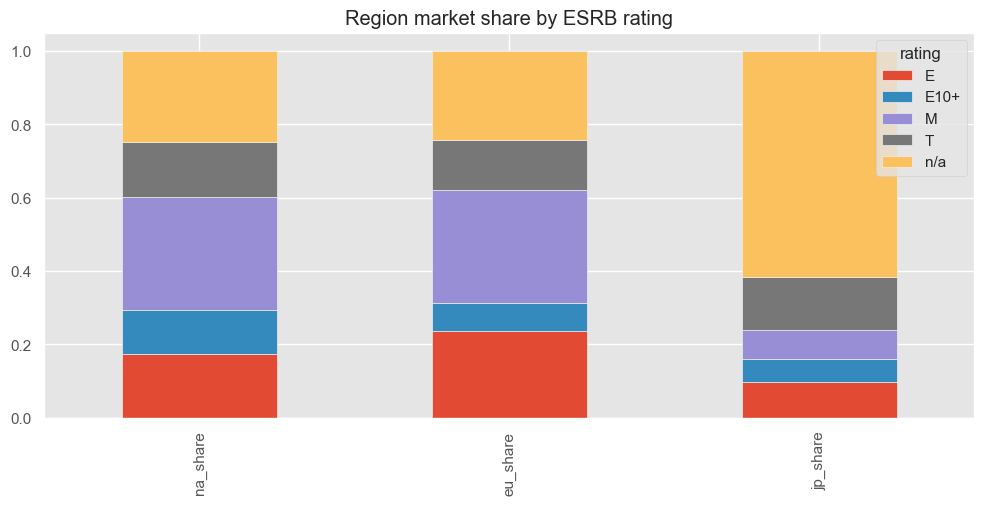

In [34]:
# оценим объем продаж игр разных рейтингов ESRB по трем регионам
esrb_sales = actual_data.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

# добавим столбцы с долей рынка по каждому из рейтингов
esrb_sales['na_share'] = esrb_sales['na_sales'] / esrb_sales['na_sales'].sum()
esrb_sales['eu_share'] = esrb_sales['eu_sales'] / esrb_sales['eu_sales'].sum()
esrb_sales['jp_share'] = esrb_sales['jp_sales'] / esrb_sales['jp_sales'].sum()
#display(esrb_sales)

#отобразим на графике
esrb_sales[['na_share', 'eu_share', 'jp_share']].T.plot(kind='bar', title='Region market share by ESRB rating', stacked=True)
plt.show()

Заметно влияние рейтинга ESRB на продажи в Северной Америке и Европе. Около 80% игр продаются с присвоенным рейтингом. Причем основную долю составляет рейтинг **M» («Mature») — «Для взрослых»**: Материалы игры не подходят для подростков младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории.

Японский рынок, в свою очередь, не так сильно привязан к присвоенному рейтингу ESRB - игры прекрасно продаются и без него. Вплоне может быть, что на территории Японии действует какая-то другая рейтинговая система, не ESRB. 

---
## Промежуточные выводы

**Популяность игровых платформ на разных рынках:**

- Рынок NA - На американском рынке самые популярные платформы - стационарный игровые консоли, причем лидирует консоль от американской конмпании Microsoft - Xbox360. Также очень популярны консоли от Sony - PS3 и пришедшая ей на смену PS4. Причем флагман от Sony может похвастаться более высокими продажами игр, по сравнению с последней консолью от Microsoft.

- Рынок EU - На рынке Европы наиболее популярны консоли от Sony - PS3 и PS4. Американские XBox гораздо менее распространены.

- Рынок JP - На японском рынке весьма сильно распространены мобильные консоли - лидирует 3DS, в топ-5 также попали PSVita и WiiU. Из стационарных консолей популярны консоли от Sony - PS3 и PS4. Консоли от Microsoft не популярны на японском рынке

**Типичные портреты игроков**:

- Игрок из Северной Америки - предпочитает стационарные консоли, высоко ценит как консоли от Microsoft, так и от Sony. Любит жанры Action, Shooter, Sports и RPG

- Игрок из Европы - предпочтениями похож на игрока из Северной Америки, однако больше любит консоли от Sony

- Игрок из Японии - предпочитает мобильные консоли, на которых играет в RPG и Action игры. Играет на японских консолях, XBox от Microsoft не жалует.

**Влияние рейтинга ESRB на продажи:**
- В Северной Америке и Европе заметна важная роль рейтинга. Около 80% игр продаются с присвоенным рейтингом, основной из которых "M" - для взрослых.
- В Японии более половины игр продаются без присвоенного рейтинга. Вероятно, в Японии действует какая-то своя собственная рейтинговая система.



---
# Проверка гипотез

Задание:`проверить гипотезы:`
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.`

---
**Проверка гипотезы "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"**

- нулевая гипотеза : "Средние пользовательские рейтинги платформ Xbox One и PC равны"
- альтернативная гипотеза : "Средние пользовательские рейтинги платформ Xbox One и PC НЕ равны"

In [35]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

# совокупность пользовтаельских оценок игр Xbox One
user_score_xone = actual_data.query('platform == "XOne" and user_score.isna()==False ')['user_score']  

# совокупность пользовтаельских оценок игр PC
user_score_pc = actual_data.query('platform == "PC" and user_score.isna()==False ')['user_score']

results = st.ttest_ind( user_score_xone, user_score_pc)

print('Вероятность нулевой гипотезы (p-значение) : ', round(results.pvalue * 100,1), '%')

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Вероятность нулевой гипотезы (p-значение) :  27.8 %
Не получилось отвергнуть нулевую гипотезу


**Не отвергаем гипотезу** "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые".

In [36]:
# Приведены два датасета: сумма покупок, совершённых за месяц посетителями ...

sample_1 = [3071, 3636, 3454, 3151, 2185, 3259, 1727, 2263, 2015,
2582, 4815, 633, 3186, 887, 2028, 3589, 2564, 1422, 1785,
3180, 1770, 2716, 2546, 1848, 4644, 3134, 475, 2686,
1838, 3352]
sample_2 = [1211, 1228, 2157, 3699, 600, 1898, 1688, 1420, 5048, 3007,
509, 3777, 5583, 3949, 121, 1674, 4300, 1338, 3066,
3562, 1010, 2311, 462, 863, 2021, 528, 1849, 255,
1740, 2596]
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
sample_1,
sample_2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:

    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1912450522572209
Не получилось отвергнуть нулевую гипотезу


---
**Проверка гипотезы "Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные."**

- нулевая гипотеза : "Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») **равны**"
- альтернативная гипотеза : "Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») **не равны**."

In [37]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

# совокупность пользовтаельских оценок игр жанра Action
user_score_action = actual_data.query('genre == "Action" and user_score.isna()==False ')['user_score'] 

# совокупность пользовтаельских оценок игр жанра Sports
user_score_sports = actual_data.query('genre == "Sports" and user_score.isna()==False ')['user_score'] 

results = st.ttest_ind( user_score_action, user_score_sports)

print('Вероятность нулевой гипотезы (p-значение) : ', round(results.pvalue * 100,1), '%')

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Вероятность нулевой гипотезы (p-значение) :  0.0 %
Отвергаем нулевую гипотезу


**Отвергаем нулевую гипотезу**, cредние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») **не равны**.

---
# Общий вывод


В рамках исследования удалось оценить статистику по рынку продаж компьютерных игр с 1980 по 2016 годы

Основа для исследования - выгрузка с историческими данными по выходу игр на разных платформах и количестве проданных копий в разных регионах мира. Выгрузка содержала данные с хорошим уровнем качества - без дубликатов и значительного количества пропусков. Исключением были только данные пользовательских оценок, оценок критиков и возрастном рейтинге ESRB - эти данные отсутствуют примерно у половины игр.

**Рынок видеоигр прошел через несколько крупных этапов, когда значительно менялось количество новых игр:**
- Заря индустрии с 1980 по 1994 годы выпускалось незначительное количество игр
- Бурный рост с 1995 по 2009 годы, доросший вплоть до 1400 игр/год
- Падение с 2009 до 2012 года, с выходом на плато в 400-600 игр в год, сохраняющимся в периоде 2012-2016
- Период 2015-2016 года считаем актуальным для прогнозирования ситуации на рынке в 2017 году

**Оценка разных игровых платформ в последние годы:**
- В Северной Америке и Европе лидирует PS4, следом идет Xbox One
- В Японии больше предпочитают мобильные консоли, тогда как в Северной Америке и Европе - стационарные
- Средний срок активной жизни игровой платформы составляет 5-8 лет
- Самые продаваемые игры выходили на WiiU 
- PS4, XOne, 3DS - наиболее перспективные консоли по объему продаж новых игр в 2017 году
- PC и PSV также можно отнести к потенциально интересным на 2017 год

**Дополнительно был сформирован образ типичного игрока для разных регионов:**
- Игрок из Северной Америки - предпочитает консоли PlayStation и XBox. Kюбит жанры Action, Shooter, Sports
- Игрок из Европы - предпочтениями похож на игрока из Северной Америки, однако гораздо больше предпочитает PS4. В отличие от остальных часто играет и на PC
- Игрок из Японии - предпочитает мобильные консоли, на которых играет в RPG и Action игры. Играет на японских консолях, XBox от Microsoft не жалует.

При этом оценки игроков никак не связаны с объемом продаж, в отличие от оценок критиков, где корреляция с продажами сильно выше.

Рейтинг ESRB важен для продаж в Европе и Америке, тогда как в Японии его наличие не принципиально.
 
**Также были проверены две гипотезы:**
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковы - **не удалось опровергнуть**.
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») равны - **гипотезу отвергли**

В качестве подведения итогов можно порекомендовать в 2017 году разработку игр для платформ PS4 и XOne для всех регионов - т.к. их срок актовной жизни еще не подходит к концу. С осторожностью можно проработать разработку игр для Nintendo 3DS. Отдельно для Европейского рынка будут популярны игры на PC, а для Японии - на PSVita. 

Игры жанров Action, Shooter, Sports и RPG будут хорошо продаваться в Европе и Америке, тогда как в Японии лучше сконцентрироваться только на Action и RPG. 

## Бонус

In [38]:
data_games = pd.read_csv('games.csv') #'/datasets/games.csv'

In [39]:
data_games.columns = map(str.lower, data_games.columns)

In [40]:
data_games = data_games.dropna(subset = ['year_of_release', 'name', 'genre'])

In [41]:
data_games['user_score'] = data_games['user_score'].replace('tbd', np.nan).astype('float')

In [42]:
data_games['rating'] = data_games['rating'].fillna('unknown')

In [43]:
data_games['total_sales'] = data_games[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

In [44]:
# check
# круги + категория другие
def graph (df, year, region, name, axes):
    
    df = df.query('year_of_release >= @year')
    
    sales = df.pivot_table(index='platform', 
                           values=region, 
                           aggfunc='sum').nlargest(5, region)
    
    sales = sales.reset_index()
    
    sales = (
            sales.append({'platform': 'Other', region: df[region].sum() 
                       - sales[region].sum()}, ignore_index= True)
         )
    
    
    sales.columns = ['platform', 'sales']
    sales.plot(kind='pie',
               y="sales",
               
               autopct='%1.0f%%',
               wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
               textprops={'size': 'x-large'}, labels = sales.platform,
               
               legend=False, 
               title = f"Популярность платформ в {name} ", 
               ax = axes).set(ylabel='')
    plt.tight_layout()

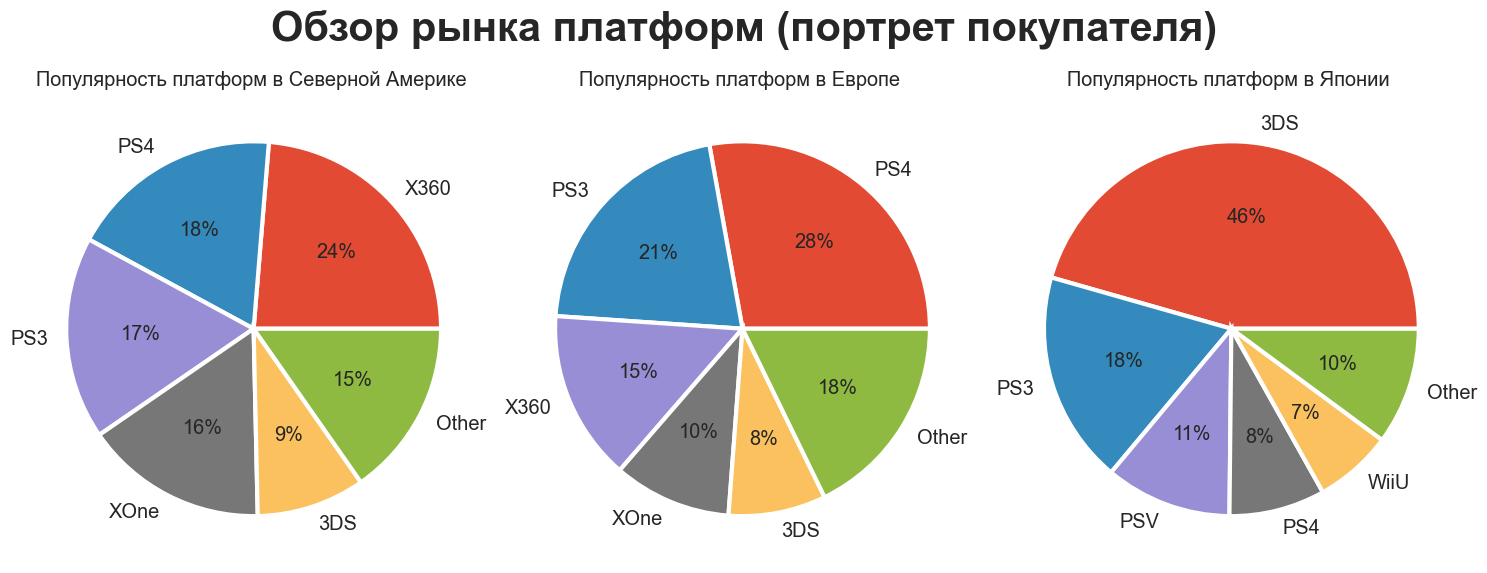

In [45]:
# check
# круги в ряд
fig, axes = plt.subplots(1, 3, figsize = (15,6))
fig.suptitle('Обзор рынка платформ (портрет покупателя)', fontsize = 30, fontweight='bold')

x_year = 2012

graph(data_games, x_year, 'na_sales', 'Северной Америке', axes[0])
graph(data_games, x_year,'eu_sales', 'Европе', axes[1])
graph(data_games, x_year, 'jp_sales', 'Японии', axes[2])

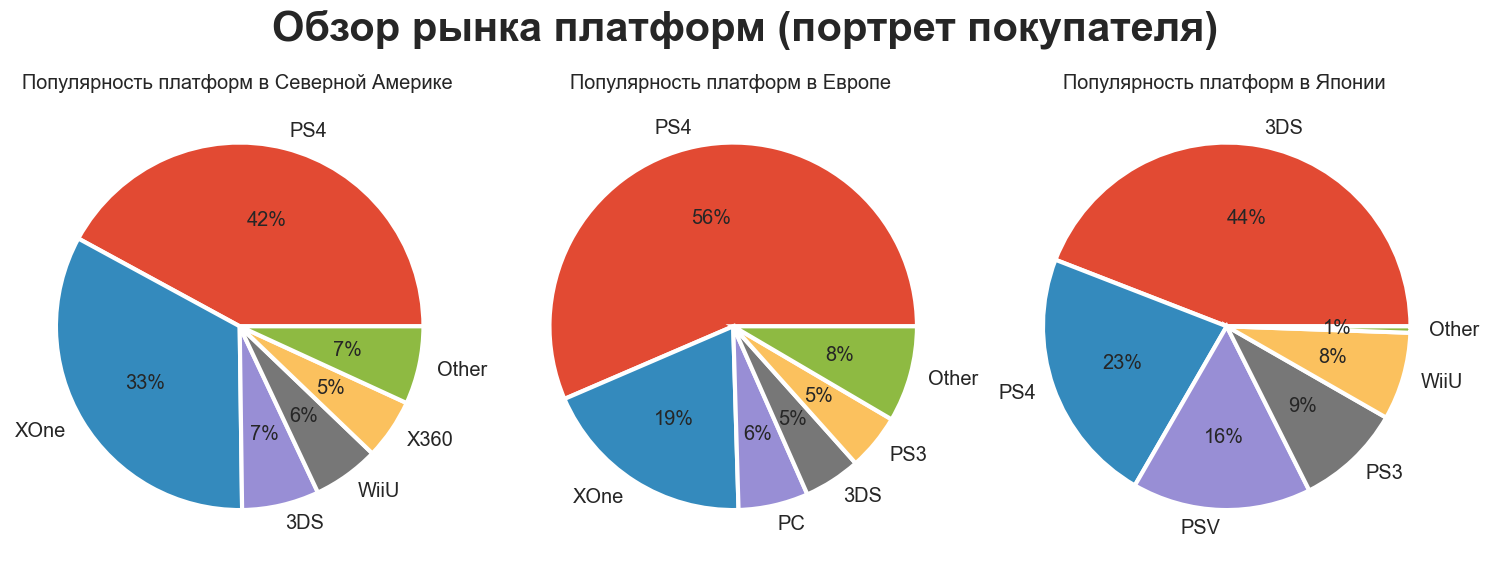

In [46]:
# check
# круги в ряд
fig, axes = plt.subplots(1, 3, figsize = (15,6))
fig.suptitle('Обзор рынка платформ (портрет покупателя)', fontsize = 30, fontweight='bold')

x_year = 2015

graph(data_games, x_year, 'na_sales', 'Северной Америке', axes[0])
graph(data_games, x_year,'eu_sales', 'Европе', axes[1])
graph(data_games, x_year, 'jp_sales', 'Японии', axes[2])